Inferring demography and mutation spectrum history for human populations
==
- Plots using nextflow pipeline output in `output/` directory

In [1]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import tensorly
from tensorly.decomposition import non_negative_parafac
import pandas as pd
import mushi.composition as cmp

mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

/net/gs/vol1/home/wsdewitt/miniconda3/envs/1KG/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [2]:
output = 'output_30x'
# output = 'output_phase3'

## Inspect one population

In [3]:
t_gen = 29

Compare 30x to phase 3

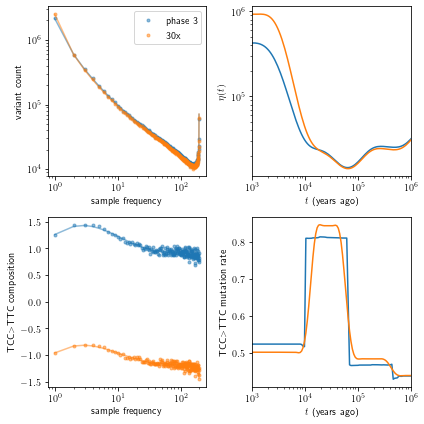

In [7]:
ksfs_phase3 = pickle.load(open(f'output_phase3/europulse_mushi/EUR_CEU/dat.pkl', 'rb'))[-2]
ksfs_30x = pickle.load(open('output_30x/europulse_mushi/EUR_CEU/dat.pkl', 'rb'))[-2]

plt.figure(figsize=(6, 6))

plt.subplot(221)
ksfs_phase3.plot_total(kwargs=dict(ls='', label='phase 3', marker='.', alpha=0.5, c='C0'),
                       line_kwargs=dict(alpha=0.5, c='C0'))
ksfs_30x.plot_total(kwargs=dict(ls='', label='30x', marker='.', alpha=0.5, c='C1'),
                    line_kwargs=dict(alpha=0.5, c='C1'))
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.subplot(222)
ksfs_phase3.eta.plot(t_gen=t_gen)
ksfs_30x.eta.plot(t_gen=t_gen)
plt.xlim(1e3, 1e6)

plt.subplot(223)
ksfs_phase3.plot(('TCC>TTC',), clr=True, kwargs=dict(ls='', marker='.', alpha=0.5, c='C0'), line_kwargs=dict(alpha=0.5, c='C0'))
ksfs_30x.plot(('TCC>TTC',), clr=True, kwargs=dict(ls='', marker='.', alpha=0.5, c='C1'), line_kwargs=dict(alpha=0.5, c='C1'))
plt.ylabel('TCC$>$TTC composition')

plt.subplot(224)
ksfs_phase3.mu.plot(('TCC>TTC',), t_gen=t_gen, c='C0')
ksfs_30x.mu.plot(('TCC>TTC',), t_gen=t_gen, c='C1')
plt.ylabel('TCC$>$TTC mutation rate')
plt.xlim(1e3, 1e6)

plt.tight_layout()
plt.savefig('plots/30xVsPhase3.pdf')

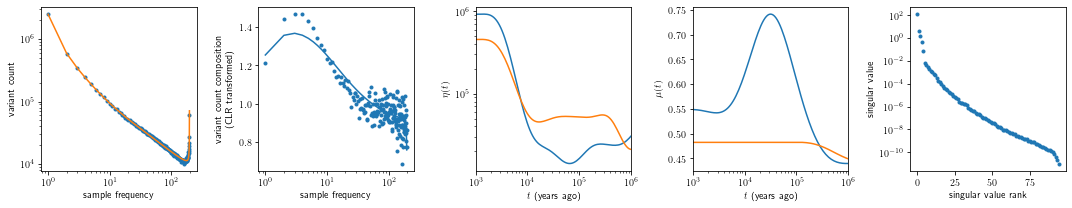

In [63]:
ksfs = pickle.load(open(f'{output}/mush/EUR_CEU/dat.pkl', 'rb'))[-2]
ksfs_ref = pickle.load(open(f'{output}/mush/AFR_YRI/dat.pkl', 'rb'))[-2]

# # ksfs.clear_eta()
# # ksfs.r = None
# # ksfs.infer_eta(ksfs.mu0, (0, 4e2), (3, 2e-2), ridge_penalty=1e-4, #eta_ref=ksfs_ref.eta,
# # #                folded=True,
# # #                pts=ksfs_ref.eta.m - 1, ta=ksfs_ref.eta.change_points[-1],
# #                pts=200, ta=2e5,
# #                max_iter=300, trend_kwargs=dict(max_iter=30), verbose=True)
# ksfs.clear_mu()
# ksfs.r_vector = None
# ksfs.infer_mush((0, 2e2), (3, 2e0), rank_penalty=2e2, hard=False, ridge_penalty=1e-4,#  2e3, mu_ref=ksfs_ref.mu,
# #                 misid_penalty=1e2,
#                 max_iter=100, trend_kwargs=dict(max_iter=30), verbose=True)

plt.figure(figsize=(15, 3))

plt.subplot(151)
# ksfs_ref.plot_total()
ksfs.plot_total()
plt.xscale('log')
plt.yscale('log')

plt.subplot(152)
ksfs.plot(('TCC>TTC',), clr=True, kwargs=dict(ls='', marker='.'))
# ksfs.plot(clr=True, kwargs=dict(ls='', marker='.'))
# ksfs.plot(clr=True, kwargs=dict(ls='', marker='.', alpha=0.1), line_kwargs=dict(alpha=0.1))

plt.subplot(153)
ksfs.eta.plot(t_gen=t_gen)
ksfs_ref.eta.plot(t_gen=t_gen)
plt.xlim(1e3, 1e6)
# plt.ylim(1e4, 1e6)

plt.subplot(154)
# ksfs.mu.plot(t_gen=t_gen, c='C0', clr=True, alpha=0.2)
# ksfs_ref.mu.plot(t_gen=t_gen, c='C1', clr=True, alpha=0.2)
ksfs.mu.plot(('TCC>TTC',), t_gen=t_gen)
ksfs_ref.mu.plot(('TCC>TTC',), t_gen=t_gen)
plt.xlim(1e3, 1e6);

plt.subplot(155)
plt.plot(np.linalg.svd(cmp.ilr(ksfs.mu.Z), compute_uv=False), '.')
plt.yscale('log')
plt.xlabel('singular value rank')
plt.ylabel('singular value')

plt.tight_layout()
plt.show()

In [64]:
import mushi
np.linalg.matrix_rank(mushi.composition.ilr(ksfs.mu.Z))

95

In [ ]:
ksfs.r, ksfs.r_vector

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
ksfs.plot(clr=True, kwargs=dict(alpha=0.25, ls='', marker='o',
                                          ms=3, mfc='none', rasterized=True),
                    line_kwargs=dict(ls=':', marker='.', ms=2, alpha=0.25,
                                     lw=1, rasterized=True))
plt.ylabel('variant count composition')
plt.subplot(122)
ksfs.μ.plot(t_gen=t_gen, clr=False, alpha=0.5, lw=2)
plt.xscale('log')
plt.ylabel('mutation rate')
plt.xlim([1e3, 1e6])
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 3))
df = pd.Series(ksfs.r_vector, index=[x[:3] + '.' + x[5] for x in ksfs.mutation_types.values], name='misid rate')
df.plot.bar()

## Bootstrap samples

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for f in glob.glob(f'{output}/bootstrap/*/dat*'):
    ksfs = pickle.load(open(f, 'rb'))[-2]

    plt.sca(axes[0])
    ksfs.eta.plot(t_gen=t_gen, alpha=0.1, c='k')

    plt.sca(axes[1])
    ksfs.mu.plot(('TCC>TTC',), t_gen=t_gen, alpha=0.2, c='k')
    
plt.sca(axes[0])
plt.xlim(1e3, 1e6)
plt.ylim(1e4, 1e6)

plt.sca(axes[1])
plt.xlim(1e3, 1e6)

plt.tight_layout()
plt.savefig('plots/bootstrap.pdf')

## $\eta$ parameter sweep for CEU population

In [ ]:
sweep_data = defaultdict(list)

for i, f in enumerate(glob.glob(f'{output}/eta_sweep/*/EUR_CEU/dat*')):
    alpha_params, beta_params, ksfs, population = pickle.load(open(f, 'rb'))
    k, λ = alpha_params[0]
    sweep_data[k].append([λ, ksfs.loss(), ksfs])

# delta loss
for k in sorted(sweep_data):
    sweep_data[k] = np.array(sorted(sweep_data[k]))
    sweep_data[k][:, 1] = sweep_data[k][:, 1] - sweep_data[k][0, 1]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

max_idx = 14

for k in range(4):
    
    plt.sca(axes[0])
    λs, losss, ksfss = sweep_data[k][:max_idx].T
    plt.plot(λs, losss, label=f'$k={k}$')
    
    for λ, loss, ksfs in zip(λs, losss, ksfss):
#         if (k, λ) in ((0, λs[10]), (1, λs[4]), (2, λs[8]), (3, λs[5])):

#             plt.sca(axes[0])
#             plt.plot(λ, loss, alpha=0.5, marker='o', color=f'C{k}', markeredgecolor='k', ms=10)

        plt.sca(axes[1])
        ksfs.eta.plot(t_gen=t_gen, alpha=0.5, lw=1, color=f'C{k}')

        plt.sca(axes[2])
        ksfs.mu.plot(('TCC>TTC', ), t_gen=t_gen, alpha=0.5, lw=1, color=f'C{k}')

plt.sca(axes[0])
plt.xlabel(r'$\alpha_k$')
plt.ylabel(r'$\Delta$ loss')
plt.xscale('symlog')
plt.ylim(None, 1e4)
# plt.yscale('symlog')
plt.legend()


plt.sca(axes[0])
plt.xlim(0, None)
plt.sca(axes[1])
plt.xlim(1e3, 1e6)
plt.ylim(1e4, 1e6)
plt.sca(axes[2])
plt.xlim(1e3, 1e6)

plt.tight_layout()
plt.savefig('plots/eta_sweep.pdf')

## $\boldsymbol\mu$ parameter sweep for CEU population

In [ ]:
sweep_data = defaultdict(list)

for i, f in enumerate(glob.glob(f'{output}/mu_sweep/*/EUR_CEU/dat*')):
    alpha_params, beta_params, ksfs, population = pickle.load(open(f, 'rb'))
    k, λ = beta_params[0]
    sweep_data[k].append([λ, ksfs.loss(), ksfs])

# delta loss
for k in sorted(sweep_data):
    sweep_data[k] = np.array(sorted(sweep_data[k]))
    sweep_data[k][:, 1] = sweep_data[k][:, 1] - sweep_data[k][0, 1]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for k in (0,): #range(4):
    
    plt.sca(axes[0])
    λs, losss, ksfss = sweep_data[k].T
    plt.plot(λs, losss, label=f'$k={k}$', c='k')
    
    for λ, loss, ksfs in zip(λs, losss, ksfss):
        if 1e2 < λ < 1.5e3:

            plt.sca(axes[0])
            plt.plot(λ, loss, alpha=0.5, marker='o', ms=10, markeredgecolor='k')#, color=f'C{k}')

            plt.sca(axes[1])
            ksfs.eta.plot(t_gen=t_gen, alpha=0.5, lw=3)#, color=f'C{k}')
            
            plt.sca(axes[2])
            ksfs.mu.plot(('TCC>TTC', ), t_gen=t_gen, alpha=0.5, lw=3)#, color=f'C{k}')

plt.sca(axes[0])
plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\Delta$ loss')
plt.xscale('symlog')
# plt.ylim(None, 4e3)
# plt.yscale('symlog')
# plt.legend()


plt.sca(axes[0])
plt.xlim(0, None)
plt.sca(axes[1])
plt.xlim(1e3, 1e6)
plt.sca(axes[2])
plt.xlim(1e3, 1e6)

plt.tight_layout()
plt.savefig('plots/mu_sweep.pdf')

## Point estimates for TCC pulse
- Make a tidy plot with the regularization parameters indicated by points in previous plots
- Use all EUR populations

In [ ]:
for method in ('mushi', 'Relate', 'Tennessen'):
    print(method)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

    files = sorted(glob.glob(f'{output}/europulse_{method}/*/dat.pkl'))
    for idx, file in enumerate(files):
        pop = file.split('/')[2].split('_')[1]
        beta_params, ksfs, population = pickle.load(open(file, 'rb'))[-3:]
        
        plt.sca(axes[0, 0])
        ksfs.plot_total(kwargs=dict(ls='', alpha=0.5, marker='o', ms=5, mfc='none', c=f'C{idx}', label=pop, rasterized=True),
                        line_kwargs=dict(c=f'C{idx}', ls=':', marker='.', ms=3, alpha=0.5, lw=1, rasterized=True),
                        fill_kwargs=dict(color=f'C{idx}', alpha=0))
        plt.xscale('log')
        plt.yscale('log')
        plt.legend(fontsize=6, loc='upper right')
        if idx < len(files) - 1:
            plt.xlabel(None)

        plt.sca(axes[0, 1])
        ksfs.eta.plot(t_gen=t_gen, lw=2, label=pop, alpha=0.75, c=f'C{idx}')
        plt.xlim([1e3, 1e6])
        plt.legend(fontsize=6, loc='upper right')
        if idx < len(files) - 1:
            plt.xlabel(None)

        plt.sca(axes[1, 0])
        ksfs.plot(('TCC>TTC',), clr=True,
                  kwargs=dict(ls='', c=f'C{idx}', marker='o', ms=5, mfc='none', alpha=0.5, label=pop, rasterized=True),
                  line_kwargs=dict(c=f'C{idx}', ls=':', marker='.', ms=3, alpha=0.5, lw=1, rasterized=True))
        plt.ylabel('TCC$\\to$TTC component of\nvariant count composition')
        plt.legend(fontsize=6)

        plt.sca(axes[1, 1])
        plt.gca().set_prop_cycle(None)
        ksfs.mu.plot(('TCC>TTC',), t_gen=t_gen, clr=False, c=f'C{idx}', alpha=0.75, lw=2, label=pop)
        plt.ylabel('TCC$\\to$TTC mutation intensity')
        plt.xlim([1e3, 1e6])
        plt.legend(fontsize=6)

    plt.tight_layout()
    plt.savefig(f'plots/europulse_{method}.pdf')
    plt.show()

## Inferring $\eta$ from folded SFS for each population

In [4]:
label_map = dict(AFR='African', AMR='Amerindian', EAS='East Asian', EUR='European', SAS='South Asian')

In [5]:
files = glob.glob(f'{output}/mush_folded/*/dat.pkl')

ksfs_dict = {}
pops = defaultdict(list)

for file in files:
    super_pop, pop = file.split('/')[2].split('_')
    alpha_params, beta_params, ksfs, population = pickle.load(open(file, 'rb'))
    pops[super_pop].append(pop)
    ksfs_dict[pop] = ksfs

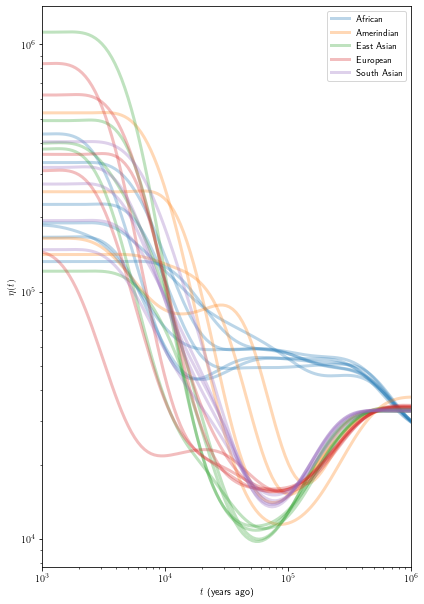

In [6]:
fig = plt.figure(figsize=(6, 1.7 * len(pops)))
for idx_super, super_pop in enumerate(sorted(pops)):
    for idx, pop in enumerate(pops[super_pop]):
        ksfs_dict[pop].eta.plot(t_gen=t_gen, lw=3, label=label_map[super_pop] if idx == 0 else None, alpha=0.3, c=f'C{idx_super}')
        plt.xlim([1e3, 1e6])
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig('plots/etas_folded.pdf')

## Inferring $\eta$ from unfolded SFS for each population

In [7]:
files = glob.glob(f'{output}/mush/*/dat.pkl')

ksfs_dict = {}
pops = defaultdict(list)

for file in files:
    super_pop, pop = file.split('/')[2].split('_')
    alpha_params, beta_params, ksfs, population = pickle.load(open(file, 'rb'))
    pops[super_pop].append(pop)
    ksfs_dict[pop] = ksfs

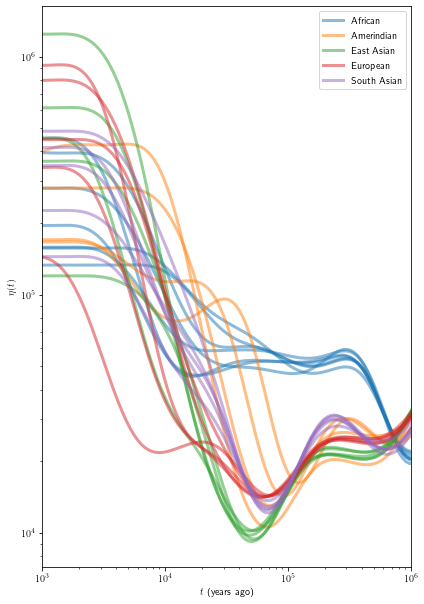

In [8]:
fig = plt.figure(figsize=(6, 1.7 * len(pops)))
for idx_super, super_pop in enumerate(sorted(pops)):
    pops[super_pop] = sorted(pops[super_pop])
    for idx, pop in enumerate(pops[super_pop]):
        ksfs_dict[pop].eta.plot(t_gen=t_gen, lw=3, label=label_map[super_pop] if idx == 0 else None, alpha=0.5, c=f'C{idx_super}')
        plt.xlim([1e3, 1e6])
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('plots/etas.pdf')

Same as above, stratified by super-population, and including SFS fit

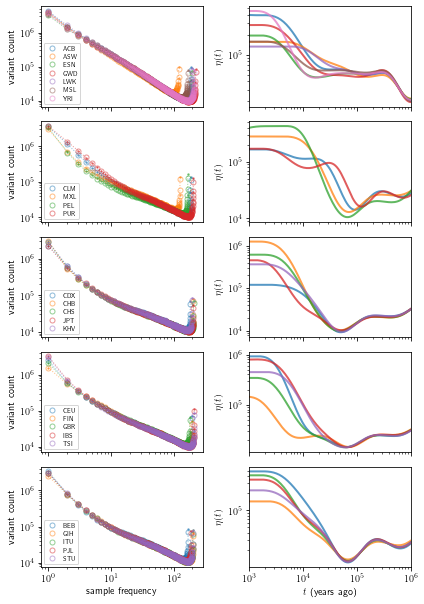

In [9]:
fig, axes = plt.subplots(len(pops), 2, sharex='col', figsize=(6, 1.7 * len(pops)), squeeze=False)
for idx_super, super_pop in enumerate(sorted(pops)):
    for idx, pop in enumerate(pops[super_pop]):
        plt.sca(axes[idx_super, 0])
        ksfs_dict[pop].plot_total(folded=False,
                                  kwargs=dict(ls='', alpha=0.5, marker='o', ms=5, mfc='none', c=f'C{idx}', label=pop, rasterized=True),
                                  line_kwargs=dict(c=f'C{idx}', ls=':', marker='.', ms=3, alpha=0.5, lw=1, rasterized=True),
                                  fill_kwargs=dict(color=f'C{idx}', alpha=0))
        plt.xscale('log')
        plt.yscale('log')
        plt.legend(fontsize=6, loc='lower left')
        if idx_super < len(pops) - 1:
            plt.xlabel(None)
        plt.sca(axes[idx_super, 1])
        ksfs_dict[pop].eta.plot(t_gen=t_gen, lw=2, alpha=0.75, c=f'C{idx}')
        plt.xlim([1e3, 1e6])
        if idx_super < len(pops) - 1:
            plt.xlabel(None)
plt.tight_layout()
plt.savefig('plots/sfsetas.pdf')

## $k$-SFS and inferred $\boldsymbol\mu$

EUR CEU


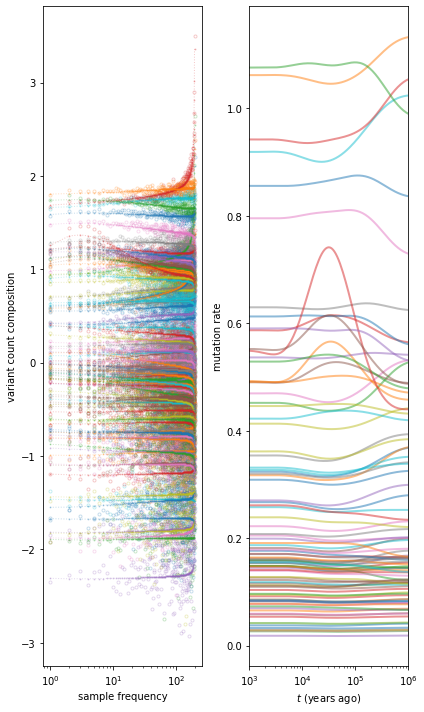

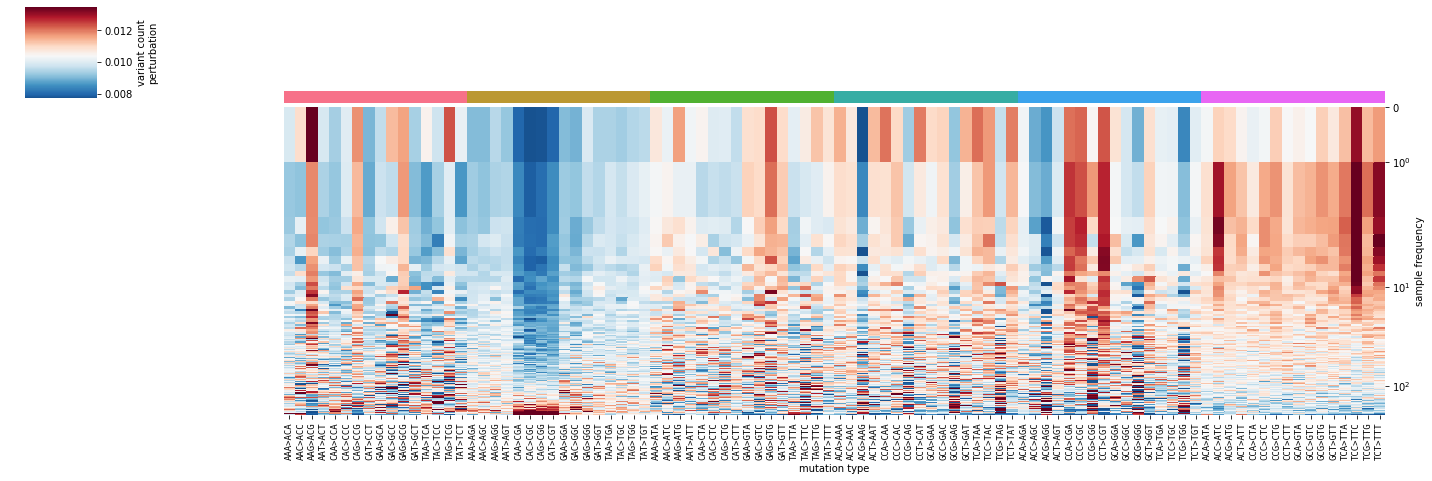

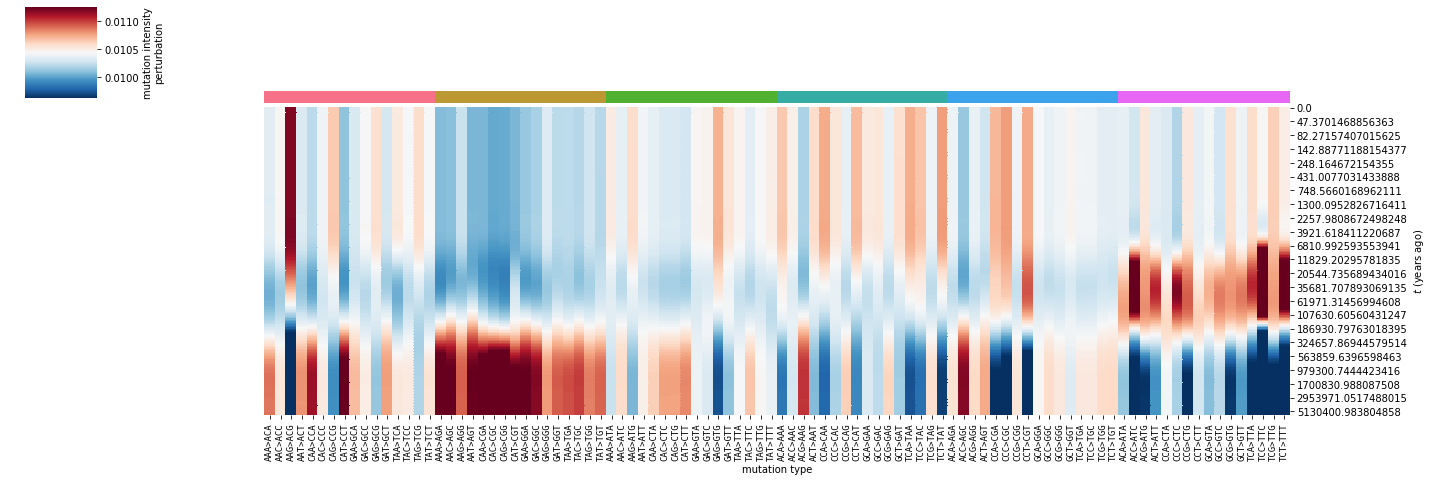

In [10]:
with mpl.rc_context(rc={'text.usetex': False}):
    super_pop = 'EUR'
    pop = 'CEU'
#     for idx_super, super_pop in enumerate(sorted(pops)):
#         for idx, pop in enumerate(pops[super_pop]):
    print(super_pop, pop)

    plt.figure(figsize=(6, 10))
    plt.subplot(121)
    ksfs_dict[pop].plot(clr=True, kwargs=dict(alpha=0.25, ls='', marker='o',
                                              ms=3, mfc='none', rasterized=True),
                        line_kwargs=dict(ls=':', marker='.', ms=2, alpha=0.25,
                                         lw=1, rasterized=True))
    plt.ylabel('variant count composition')
    plt.subplot(122)
    ksfs_dict[pop].μ.plot(t_gen=t_gen, clr=False, alpha=0.5, lw=2)
    plt.xscale('log')
    plt.ylabel('mutation rate')
    plt.xlim([1e3, 1e6])
    plt.tight_layout()
    plt.savefig('plots/mushfit.pdf')
    plt.show()

    singlets = [f'{anc}>{der}' for anc, der in zip(ksfs_dict[pop].mutation_types.str[1],
                                                   ksfs_dict[pop].mutation_types.str[5])]

    ksfs_dict[pop].mutation_types.str[1].str.cat(ksfs_dict[pop].mutation_types.str[5], sep='>')

    pal = sns.color_palette('husl', n_colors=6)
    col_map = {'A>C': pal[0], 'A>G': pal[1], 'A>T': pal[2], 'C>A': pal[3], 'C>G': pal[4], 'C>T': pal[5]}
    col_colors = [col_map[singlet] for singlet in singlets]

    ksfs_dict[pop].clustermap(figsize=(20, 7), col_cluster=False,
                              xticklabels=True, rasterized=True,
                              robust=True, cmap='RdBu_r',
                              col_colors=col_colors)
    plt.show()

    ksfs_dict[pop].μ.clustermap(t_gen=t_gen,
                                figsize=(20, 7), col_cluster=False, xticklabels=True, rasterized=True,
                                robust=True, cmap='RdBu_r',
                                col_colors=col_colors)
    plt.show()

#             # just first pop from each superpop
#             break
#         # break after first superpop
#         break

## Tensor decomposition and mutation signature dynamics
### Non-negative CP decomposition

Stack the MuSHs for each population, scaled to site-wise rates, to form a tensor of order 3

In [65]:
sorted_triplets = [f'{a5}{a}{a3}>{a5}{d}{a3}' for a in 'AC' for d in 'ACGT' if d != a for a5 in 'ACGT' for a3 in 'ACGT']
masked_genome_size = pd.read_csv(f'{output}/masked_size.tsv', sep='\t', header=None, index_col=0, names=('count',))
targets = np.array([masked_genome_size.loc[triplet.split('>')[0], 'count'] for triplet in sorted_triplets])

Z = np.concatenate([(ksfs_dict[pop].mu.Z / targets)[np.newaxis, :, :]
                    #ksfs_dict[pop].mu.Z[np.newaxis, :, :]
                    for super_pop in sorted(pops)
                    for pop in pops[super_pop]], 0)

NNCP decomposition to extract factors for each dimension: sample, time, and mutation type. We try a range of ranks and assess reconstruction error at each.

rank 1 decomposition, error = 0.01909354501930803
rank 2 decomposition, error = 0.012894004138488428
rank 3 decomposition, error = 0.009681290761114632
rank 4 decomposition, error = 0.009150061694030112
rank 5 decomposition, error = 0.009065696432403257
rank 6 decomposition, error = 0.008916469278896513
rank 7 decomposition, error = 0.0087908807167449
rank 8 decomposition, error = 0.008568483883491112


/net/gs/vol1/home/wsdewitt/miniconda3/envs/1KG/lib/python3.7/site-packages/tensorly/backend/core.py:780: RuntimeWarning: divide by zero encountered in true_divide
  V = np.dot(matrix.T.conj(), U * np.where(np.abs(S) <= np.finfo(S.dtype).eps, 0, 1/S)[None, :])


rank 9 decomposition, error = 0.008625306043636611
rank 10 decomposition, error = 0.008625182917650425


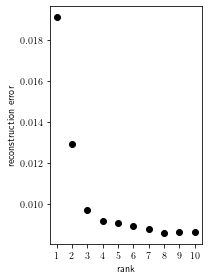

In [138]:
ranks = range(1, 11)
errors = []
tensors = {}
for rank in ranks:
    # NOTE: normalize_factors=True leads to instability for some reason
    tensor, error = non_negative_parafac(Z, rank=rank,
                                         orthogonalise=False, normalize_factors=False,
                                         tol=1e-10, n_iter_max=2000, cvg_criterion='rec_error',
                                         random_state=0, return_errors=True)
    print(f'rank {rank} decomposition, error = {error[-1]}')
    errors.append(error[-1])
    tensors[rank] = tensor[1]

plt.figure(figsize=(3, 4))
plt.plot(ranks, errors, 'ko')
plt.xlabel('rank')
plt.xticks(ranks)
plt.ylabel('reconstruction error')
plt.tight_layout()
plt.savefig('plots/elbow.pdf')

Choose rank

In [145]:
rank = 4
factors_sample, factors_history, factors_signature = tensors[rank]


### Project the sample dimension factors to two principal components

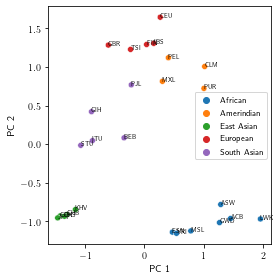

In [169]:
x, y = PCA(n_components=2, whiten=True).fit_transform(factors_sample).T
plt.figure(figsize=(4, 4))
sns.scatterplot(x=x, y=y, hue=[label_map[super_pop] for super_pop in sorted(pops)
                               for pop in pops[super_pop]])
i = 0
for super_pop in sorted(pops):
    for pop in pops[super_pop]:
        plt.annotate(pop, (x[i], y[i]), size=6)
        i += 1
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best', fontsize=8)
plt.tight_layout()
plt.savefig('plots/factors_pop.pdf')

### Project the time dimension factors to two principal components

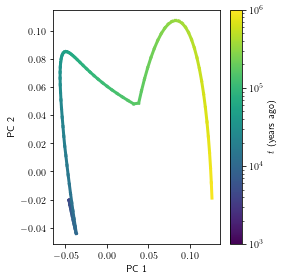

In [147]:
xy = PCA(n_components=2).fit_transform(factors_history)
idxs = (1e3 <= t_gen * ksfs_dict[pop].mu.arrays()[0][:-1]) & (t_gen * ksfs_dict[pop].mu.arrays()[0][:-1] <= 1e6)
plt.figure(figsize=(4, 4))
x = np.dstack((xy[idxs][:-1, 0], xy[idxs][1:, 0])).flatten()
y = np.dstack((xy[idxs][:-1, 1], xy[idxs][1:, 1])).flatten()
z = t_gen * np.dstack((ksfs_dict[pop].mu.arrays()[0][:-1][idxs][:-1], ksfs_dict[pop].mu.arrays()[0][:-1][idxs][:-1])).flatten()
norm = mpl.colors.LogNorm(vmin=1e3, vmax=1e6)
points = plt.scatter(x=x, y=y, c=z, s=0, norm=norm, cmap='viridis')
sns.lineplot(x=x, y=y, hue=z, hue_norm=norm, lw=3, legend=False, palette='viridis')
cbar= plt.colorbar(points)
cbar.set_label('$t$ (years ago)', rotation=90)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.tight_layout()
plt.savefig('plots/factors_history.pdf')

### Project the mutation type dimension factors to two principal components

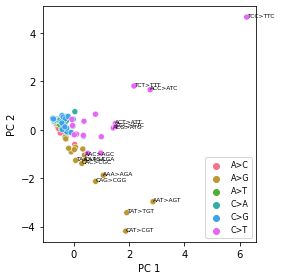

In [148]:
with mpl.rc_context(rc={'text.usetex': False}):
    singlets = [f'{anc}>{der}' for anc, der in zip(ksfs_dict[pop].mutation_types.str[1],
                                                   ksfs_dict[pop].mutation_types.str[5])]
    x, y = PCA(n_components=2, whiten=True).fit_transform(factors_signature * targets[:, None]).T
    plt.figure(figsize=(4, 4))
    sns.scatterplot(x=x, y=y, hue=singlets, palette='husl')
    for i, mutation_type in enumerate(ksfs_dict[pop].mu.mutation_types):
        if np.abs(np.array([x[i], y[i]])).max() > 1.:
            plt.annotate(mutation_type, (x[i], y[i]), size=6)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc='lower right', fontsize=8)
    plt.tight_layout()
    plt.savefig('plots/factors_mutation.pdf')

### Display mutation type loadings as mutation signatures

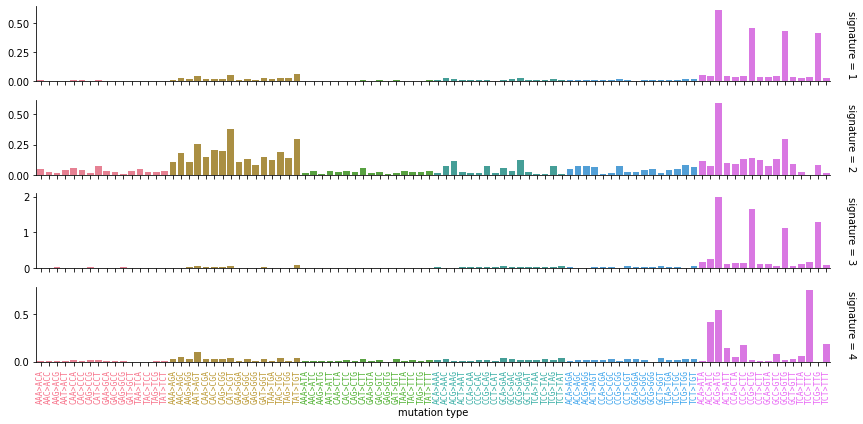

In [155]:
signature_df = pd.DataFrame(factors_signature,
                            columns=[i for i in range(1, factors_signature.shape[1] + 1)])
signature_df['mutation type'] = ksfs_dict[pop].mu.mutation_types
signature_df['singlet type'] = singlets

pal = sns.color_palette('husl', n_colors=6)
colors = {'A>C': pal[0], 'A>G': pal[1], 'A>T': pal[2],
          'C>A': pal[3], 'C>G': pal[4], 'C>T': pal[5]}
palette = [colors[singlet] for singlet in signature_df['singlet type']]
signature_df = signature_df.melt(id_vars=['mutation type', 'singlet type'], var_name='signature')

with mpl.rc_context(rc={'text.usetex': False}):
    g = sns.FacetGrid(signature_df, row='signature', aspect=8, height=1.5,
                      margin_titles=True, sharey=False)
    g = g.map(sns.barplot, 'mutation type', 'value',
              order=ksfs_dict[pop].mu.mutation_types,
              palette=palette)
    g.set_xticklabels(rotation=90, fontsize=8, family='monospace')
    for xtick, color in zip(g.axes.flat[-1].get_xticklabels(), palette):
        xtick.set_color(color)
    for ax in g.axes.flat:
        ax.set_ylabel(None)
    plt.tight_layout()
    plt.savefig('plots/signatures.pdf')
    


### Mutation signature dynamics in each population

- rows correspond to mutation signatures
- columns correspond to super populations

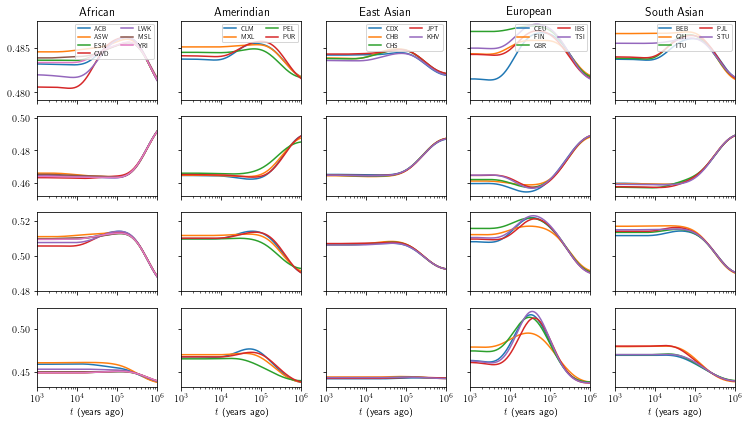

In [150]:
factors_signature_normed = factors_signature * targets[:, np.newaxis]
# factors_signature_normed = factors_signature
factors_signature_normed /= factors_signature_normed.sum(0, keepdims=True)

Z_transform = tensorly.tenalg.mode_dot(Z * targets[np.newaxis, np.newaxis, :], factors_signature_normed.T, mode=2)
# Z_transform = tensorly.tenalg.mode_dot(Z, factors_signature_normed.T, mode=2)

fig, axes = plt.subplots(Z_transform.shape[2], len(pops), sharex=True, sharey='row', figsize=(2.1 * len(pops), 1.5 * Z_transform.shape[2]))
for k in range(Z_transform.shape[2]):
    i = 0
    for idx, super_pop in enumerate(sorted(pops)):
        plt.sca(axes[k, idx])
        for idx2, pop in enumerate(pops[super_pop]):
            plt.plot(t_gen * ksfs_dict[pop].mu.arrays()[0][:-1], Z_transform[i, :, k],
                     label=pop)
            plt.xscale('log')
            plt.xlim([1e3, 1e6])
            i += 1
        if k == 0:
            plt.title(label_map[super_pop])
            plt.legend(fontsize=6, loc='upper right', ncol=2)
        elif k == Z_transform.shape[2] - 1:
            plt.xlabel('$t$ (years ago)')
plt.tight_layout()
plt.savefig('plots/signature_histories.pdf')

The same histories overlayed for all populations

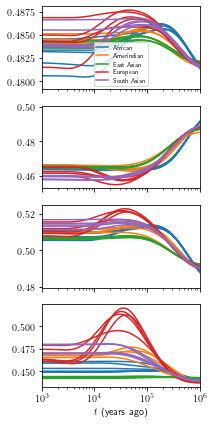

In [151]:
fig, axes = plt.subplots(Z_transform.shape[2], 1, sharex=True, sharey=False, figsize=(3, 1.5 * Z_transform.shape[2]))
for k in range(Z_transform.shape[2]):
    i = 0
    plt.sca(axes[k])
    for idx, super_pop in enumerate(sorted(pops)):
        for idx2, pop in enumerate(pops[super_pop]):
            plt.plot(t_gen * ksfs_dict[pop].mu.arrays()[0][:-1], Z_transform[i, :, k],
                     label=(label_map[super_pop] if idx2 == 0 else None), c=f'C{idx}')
            plt.xscale('log')
            plt.xlim([1e3, 1e6])
            i += 1
    if k == 0:
        plt.legend(fontsize=6)
plt.xlabel('$t$ (years ago)')
plt.tight_layout()
plt.savefig('plots/signature_histories_all.pdf')

## Global divergence in mutation spectra

### UMAP embedding of mutation signatures through time for all populations

In [157]:
time = t_gen * np.concatenate((np.array([0]), ksfs_dict[pop].μ.change_points))
time_mask = ((1e3 <= time) & (time <= 1e6))

np.random.seed(1)

embedding_init = PCA(n_components=2)
embedding_init.fit(factors_history[time_mask, :])

colors = {super_pop: f'C{idx}' for idx, super_pop in enumerate(sorted(pops))}

Z_dict = {}
i = 0
for super_pop in sorted(pops):
    for pop in pops[super_pop]:
        Z_dict[pop] = Z_transform[i, time_mask, :]
        i += 1

Z_stack = np.concatenate(np.array([Z_dict[pop] for super_pop in pops for pop in pops[super_pop]]))
embedding = umap.UMAP(n_components=2,
#                       n_neighbors=10,
#                       min_dist=0,
                      n_epochs=1000,
                      init=embedding_init.transform(Z_stack),
                      random_state=1)
embedding.fit(Z_stack)


Z_transform_dict = {pop: embedding.transform(Z_dict[pop])
                    for super_pop in pops
                    for pop in pops[super_pop]}

inside function
   (0, 0)	1.0
  (0, 1)	0.86518234
  (0, 2)	0.7297299
  (0, 3)	0.5989522
  (0, 4)	0.47768658
  (0, 5)	0.36955264
  (0, 6)	0.27698645
  (0, 7)	0.2009903
  (0, 8)	0.14113899
  (0, 9)	0.09587008
  (0, 10)	0.06297337
  (0, 11)	0.040017255
  (0, 12)	0.024624549
  (0, 13)	0.0146876825
  (0, 14)	0.008500355
  (1, 0)	0.8433873
  (1, 1)	1.0
  (1, 2)	0.8183731
  (1, 3)	0.6485212
  (1, 4)	0.4967581
  (1, 5)	0.36707026
  (1, 6)	0.26128384
  (1, 7)	0.17900173
  (1, 8)	0.11797485
  (1, 9)	0.074765205
  :	:
  (111, 338)	0.26804978
  (111, 450)	0.268432
  (111, 451)	0.25859886
  (111, 563)	0.46842453
  (111, 564)	0.26404506
  (111, 676)	0.26312202
  (111, 677)	0.24927203
  (111, 789)	0.2360767
  (111, 790)	0.23703673
  (111, 2033)	0.21366923
  (112, 111)	0.29859453
  (112, 112)	1.0
  (112, 224)	0.22697781
  (112, 225)	0.54607886
  (112, 337)	0.13425846
  (112, 338)	0.35029992
  (112, 450)	0.14041194
  (112, 451)	0.37247464
  (112, 563)	0.20552555
  (112, 564)	0.5673141
  (112, 676)	0.13

inside function
   (0, 904)	1.0
  (0, 905)	0.83176625
  (0, 906)	0.6642087
  (0, 907)	0.5098721
  (0, 908)	0.37698165
  (0, 909)	0.2700766
  (0, 910)	0.18900467
  (0, 911)	0.13068427
  (0, 912)	0.090649925
  (0, 913)	0.06424045
  (0, 919)	0.05361772
  (0, 920)	0.09266074
  (0, 921)	0.18914993
  (0, 922)	0.3062846
  (0, 923)	0.1376977
  (1, 904)	0.80909073
  (1, 905)	1.0
  (1, 906)	0.772023
  (1, 907)	0.5695556
  (1, 908)	0.4024315
  (1, 909)	0.27422082
  (1, 910)	0.18188666
  (1, 911)	0.118981525
  (1, 912)	0.07811993
  (1, 913)	0.052569542
  :	:
  (111, 1016)	0.37942612
  (111, 1125)	0.27255332
  (111, 1126)	0.6700274
  (111, 1127)	0.23826735
  (111, 1465)	0.2321418
  (111, 1466)	0.25885597
  (111, 1580)	0.21237284
  (111, 1581)	0.23949176
  (111, 2029)	0.117108464
  (111, 2030)	0.118853375
  (112, 900)	0.35548332
  (112, 901)	0.4742063
  (112, 902)	0.25045422
  (112, 1014)	0.13072805
  (112, 1015)	0.3935403
  (112, 1016)	1.0
  (112, 1126)	0.39998734
  (112, 1127)	0.5016033
  (112, 11

inside function
   (0, 1695)	1.0
  (0, 1696)	0.8411125
  (0, 1697)	0.6983258
  (0, 1698)	0.57024145
  (0, 1699)	0.45869341
  (0, 1700)	0.36178562
  (0, 1701)	0.279931
  (0, 1702)	0.21186571
  (0, 1703)	0.15688378
  (0, 1704)	0.113467395
  (0, 1705)	0.08032992
  (0, 1706)	0.055528447
  (0, 1707)	0.03759291
  (0, 1708)	0.02492961
  (0, 1709)	0.016193666
  (1, 1695)	0.8126848
  (1, 1696)	1.0
  (1, 1697)	0.7997482
  (1, 1698)	0.6267901
  (1, 1699)	0.48228437
  (1, 1700)	0.36240882
  (1, 1701)	0.26608837
  (1, 1702)	0.19024596
  (1, 1703)	0.1325173
  (1, 1704)	0.08975282
  :	:
  (111, 1467)	0.34185758
  (111, 1468)	0.17712645
  (111, 1805)	0.19475268
  (111, 1806)	1.0
  (111, 1807)	0.23354726
  (111, 2030)	0.2366751
  (111, 2031)	0.6579347
  (111, 2032)	0.40644616
  (111, 2258)	0.17643288
  (111, 2259)	0.17560014
  (112, 223)	0.25880107
  (112, 903)	0.22369011
  (112, 1128)	0.22157268
  (112, 1129)	0.368761
  (112, 1353)	0.14967707
  (112, 1354)	0.18633263
  (112, 1355)	0.17738982
  (112, 1

inside function
   (0, 2486)	1.0
  (0, 2487)	0.8791344
  (0, 2488)	0.7507929
  (0, 2489)	0.62258637
  (0, 2490)	0.49765632
  (0, 2491)	0.38161302
  (0, 2492)	0.27928567
  (0, 2493)	0.19471672
  (0, 2494)	0.12826005
  (0, 2495)	0.07956679
  (0, 2496)	0.04639426
  (0, 2497)	0.025291875
  (0, 2498)	0.012844381
  (0, 2499)	0.0060758516
  (0, 2500)	0.002671397
  (1, 2486)	0.8601489
  (1, 2487)	1.0
  (1, 2488)	0.83141947
  (1, 2489)	0.6677876
  (1, 2490)	0.513822
  (1, 2491)	0.37659875
  (1, 2492)	0.2613706
  (1, 2493)	0.17139478
  (1, 2494)	0.10517393
  (1, 2495)	0.060168847
  :	:
  (111, 2598)	0.51828015
  (111, 2708)	0.08888962
  (111, 2709)	0.20787364
  (111, 2710)	0.38412157
  (111, 2711)	0.4711439
  (111, 2823)	0.11420797
  (111, 2824)	0.126164
  (111, 2935)	0.16377708
  (111, 2936)	0.31807855
  (111, 2937)	0.44952554
  (112, 2484)	0.17518097
  (112, 2485)	0.2628887
  (112, 2595)	0.16972873
  (112, 2596)	0.33924463
  (112, 2597)	0.6115466
  (112, 2598)	1.0
  (112, 2709)	0.1963565
  (11

### Plot embedding

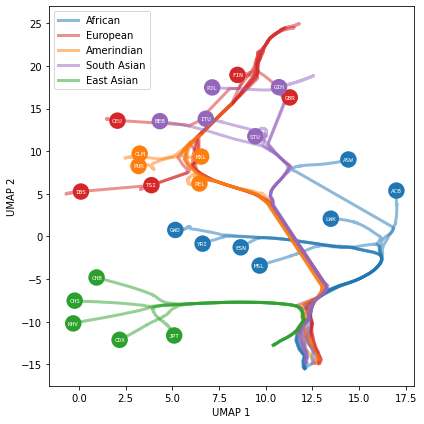

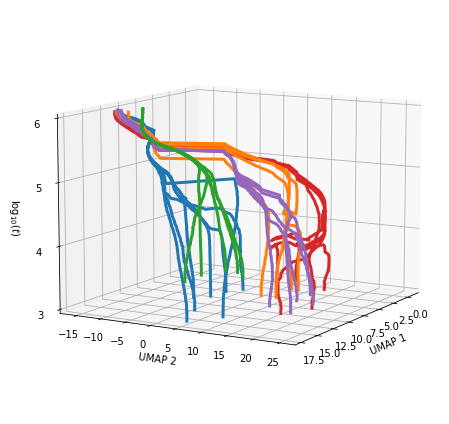

In [168]:
with mpl.rc_context(rc={'text.usetex': False}):

    plt.figure(figsize=(6, 6))
    # plt.subplot(311)
    for super_pop in pops:
        for idx2, pop in enumerate(pops[super_pop]):
            plt.plot(*Z_transform_dict[pop].T,
                     '-', lw=3, alpha=.5,
                     c=colors[super_pop],
                     label=label_map[super_pop] if idx2 == 0 else None)
            plt.annotate(pop, Z_transform_dict[pop][0, :],
                         ha='center', va='center', c='w',
                         family='monospace',
                         bbox=dict(boxstyle='circle', fc=colors[super_pop], ec=colors[super_pop], lw=2),
                         size=6)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.tight_layout()
    plt.savefig('plots/umap.pdf')
    

    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca(projection='3d')
    ax.view_init(10, 30)
    for super_pop in pops:
        for pop in pops[super_pop]:
            ax.plot(*Z_transform_dict[pop].T, np.log10(time[time_mask]),
                    '-', lw=3, alpha=1,
                    c=colors[super_pop],
                    label=super_pop if idx2 == 0 else None)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_zlabel('$\log_{10}(t)$')
    ax.set_zticks([3, 4, 5, 6])
    ax.set_zlim([3, 6])
    plt.tight_layout()
    plt.savefig('plots/umap_3d.pdf')
